In [3]:
import numpy as np
import tensorflow as tf
import pydub
import matplotlib.pyplot as plt
from art.classifiers import KerasClassifier, TFClassifier
from art.attacks import FastGradientMethod, CarliniLInfMethod, CarliniL2Method
from art.attacks.evasion import DeepFool, ProjectedGradientDescent, UniversalPerturbation
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Audio

### Read training examples

In [4]:
tfrecord_file = '/scratch1/ilya/locDoc/data/alexa/v6cx2/train_80000/_clean_speech_00_0000.tfrecord'

In [5]:
#tfrecord_file = r'C:\Users\Ruijie Zheng\py3fst\v4e_5s_val_example.tfrecord'
# tfrecord_file = r'C:\Users\Ruijie Zheng\py3fst\train_80000\_clean_speech_00_0001.tfrecord'
spec_h = 256 # 80
# set some variables that are relavant to the network
network_example_length = 19840
hop_length = 160

examples = []
specs = []
spec_labs = []
limit = 100

for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)

    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec_labs.append(eg_np.features.feature["spectrogram_label"].int64_list.value)
    spec = np.array(spec).reshape(spec_h,-1)
    specs.append(spec)
    if i > limit:
        break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [6]:
examples = np.array(examples)
specs = np.array(specs)
print(examples.shape)
print(specs.shape)

(101, 80000)
(101, 256, 500)


In [7]:
sound_i = 0
Audio(examples[sound_i], rate=16000)

### Slice the training example to feed into the network

In [8]:
batched_input = []
for i in range (specs.shape[0]):
    for j in range(specs.shape[-1]//31):
        start = 31 * j
        end = 31 * (j+1)
        batched_input.append(specs[i,:,start:end])
batched_input = np.array(batched_input)
print(batched_input.shape)

(1616, 256, 31)


## 2. Load wake word detection model

In [11]:
model_dir = '/scratch0/ilya/locDoc/adv_audio_tf_board/cortical_04.30_v6cx2/export/best_acc_exporter/1588343626'

In [12]:
# model_dir = r'C:\Users\Ruijie Zheng\py3fst\MRFAR_exporter\1586995624'
sess = tf.Session()
model = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_dir)
predictor = tf.contrib.predictor.from_saved_model(model_dir)

INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDoc/adv_audio_tf_board/cortical_04.30_v6cx2/export/best_acc_exporter/1588343626/variables/variables
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDoc/adv_audio_tf_board/cortical_04.30_v6cx2/export/best_acc_exporter/1588343626/variables/variables


In [13]:
# Load input and output tensor from model
signature = model.signature_def
signature_key = "serving_default"
input_key = "spectrograms"
output_key = "output"

x_tensor_name = signature["serving_default"].inputs[input_key].name
y_tensor_name = signature["serving_default"].outputs[output_key].name

input_x = sess.graph.get_tensor_by_name(x_tensor_name)
output_y = sess.graph.get_tensor_by_name(y_tensor_name)
output_y= tf.reshape(output_y,[-1,3])

In [14]:
input_x

<tf.Tensor 'Placeholder:0' shape=(?, 256, 31) dtype=float32>

In [15]:
output_y

<tf.Tensor 'Reshape:0' shape=(?, 3) dtype=float32>

In [16]:
masks = predictor({"spectrograms": batched_input })['output']
masks = masks.reshape([-1, 3])
test_example = batched_input[np.newaxis, 5, :, :]
labels=masks[np.newaxis, 5, :]
print(labels)

[[9.999939e-01 5.230162e-06 8.455580e-07]]


In [17]:
#Define Loss Function
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=tf.reshape(output_y, [-1]), labels=tf.cast(tf.reshape(labels, [-1]), dtype=tf.float32)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
# ART libarary wrapper around the tensorflow model
classifier = TFClassifier(
    input_ph = input_x,
    output   = output_y,
    labels_ph = labels,
    loss = loss_op,
    clip_values = (np.min(batched_input),np.max(batched_input)),
    sess = sess
)

## Load attack

Here, I load the adversarial perturbations that I have already trained. You can also adjust the parameters and try. (My experience: for universal perturbation with DeepFool attack (default settings), if you set delta to be less than 0.18, it will take too long to train.)

In [1]:
adv_file = '/scratch0/ilya/locDownloads/frank_adv_05_01/adversarial.npz'

In [6]:
data = np.load(adv_file)

In [10]:
data['arr_0'].shape

(1632, 256, 31)

In [20]:
#Find the Universal Perturbation (Default Attacker is DeepFool Attack) 
#universal_perturb = UniversalPerturbation(classifier, delta=0.18, max_iter=500)
#target = np.zeros(masks.shape)
#target[:,2]  = np.ones(masks.shape[0]) 
#adversarial = universal_perturb.generate(batched_input,target)
with np.load(adv_file) as data:
    print(data)
    uni_adversarial=data['arr_0']

In [21]:
adversarial_perturb=np.mean(uni_adversarial-batched_input, axis=0)
uniform_adversarial = adversarial_perturb+test_example
print("L2 Norm of Adversarial Perturbation {}".format(np.mean(np.abs(uniform_adversarial-test_example)**2)))

ValueError: operands could not be broadcast together with shapes (1632,256,31) (1616,256,31) 

In [15]:
print("Model output for clean example:")
print(predictor({"spectrograms": test_example })['output'])
print("Model output for adversarial example:")
print(predictor({"spectrograms": uniform_adversarial })['output']) 

Model output for clean example:
[[[0.96915305 0.00160742 0.0292396 ]]]
Model output for adversarial example:
[[[2.8253771e-32 2.8896373e-29 1.0000000e+00]]]


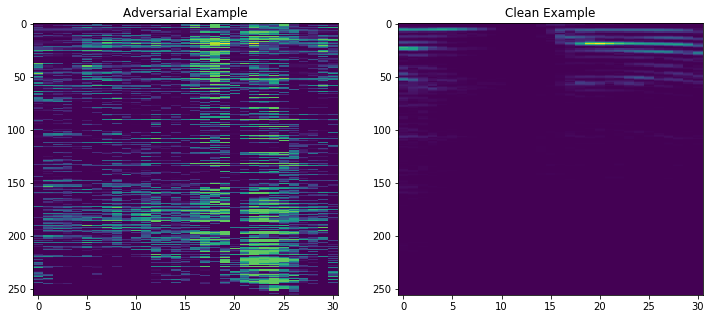

In [16]:
fig, (ax1, ax2) =plt.subplots(1, 2,figsize=(12,5))
_ = ax1.imshow(np.squeeze(uniform_adversarial,axis=0), aspect='auto')
_ = ax1.set_title("Adversarial Example")
_ = ax2.imshow( np.squeeze(test_example,axis=0), aspect='auto')
_ = ax2.set_title("Clean Example")

### Universal Perturbation with NewtonFool Attack

In [17]:
#nf_universal_perturb = UniversalPerturbation(classifier, attacker = 'newtonfool',delta=0.15, max_iter=500)
#target = np.zeros(masks.shape)
#target[:,2]  = np.ones(masks.shape[0]) 
#nf_uni_adversarial = nf_universal_perturb.generate(batched_input,target)
with np.load('nf_uniform_adversarial.npz') as data:
    print(data)
    nf_uni_adversarial=data['arr_0']

In [18]:
print("Average L2 Norm Perturbation {}".format(np.mean(np.abs(nf_uni_adversarial-batched_input)**2)))

Average L2 Norm Perturbation 0.0006275670031154762


In [19]:
nf_adversarial_perturb=np.mean(nf_uni_adversarial-batched_input, axis=0)
nf_adversarial_example = nf_adversarial_perturb+test_example

Here the thing I notice is that once I constrain the amount of perturbation of NewtonFool to a certain amouont, it will not give me the desired output (which I give as the target [0,0,1]). But still, they are indeed adversarial examples (the "power" of the adversarial example might be less)

In [20]:
print("Model output for clean example:")
print(predictor({"spectrograms": test_example })['output'])
print("Model output for adversarial example:")
print(predictor({"spectrograms": nf_adversarial_example })['output']) 

Model output for clean example:
[[[0.96915305 0.00160742 0.0292396 ]]]
Model output for adversarial example:
[[[4.6592558e-04 9.9953413e-01 8.9493357e-11]]]


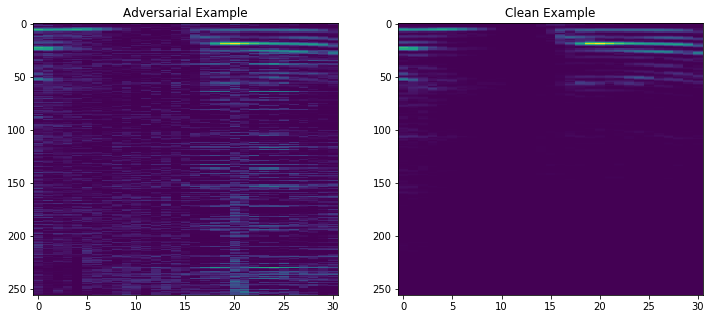

In [21]:
fig, (ax1, ax2) =plt.subplots(1, 2,figsize=(12,5))
_ = ax1.imshow(np.squeeze(nf_adversarial_example,axis=0), aspect='auto')
_ = ax1.set_title("Adversarial Example")
_ = ax2.imshow( np.squeeze(test_example,axis=0), aspect='auto')
_ = ax2.set_title("Clean Example")

### DeepFool Attack (attack on individual examples)

In [22]:
deepfool_attack = DeepFool(classifier, max_iter = 200)
target_y=np.array([0,0,1])
deepfool_adversarial = deepfool_attack.generate(x = test_example, y = target_y)
np.sum(np.abs(deepfool_adversarial-test_example)**2)

print("Model output for clean example:")
print(predictor({"spectrograms": test_example })['output'])
print("Model output for adversarial example:")
print(predictor({"spectrograms": deepfool_adversarial })['output']) 

Model output for clean example:
[[[0.96915305 0.00160742 0.0292396 ]]]
Model output for adversarial example:
[[[0.03817195 0.00258218 0.95924586]]]


In [23]:
np.mean(np.abs(deepfool_adversarial-test_example)**2)

3.2323892469682197e-07

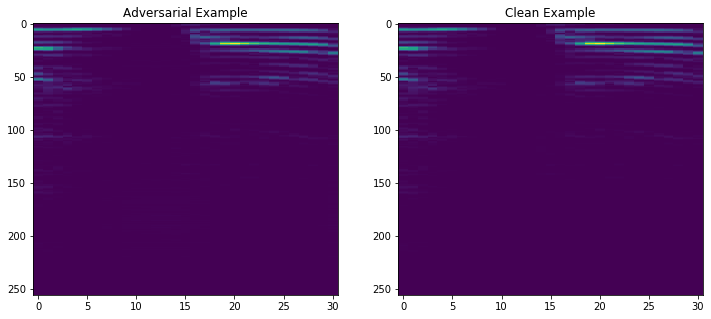

In [24]:
fig, (ax1, ax2) =plt.subplots(1, 2,figsize=(12,5))
_ = ax1.imshow(np.squeeze(deepfool_adversarial,axis=0), aspect='auto')
_ = ax1.set_title("Adversarial Example")
_ = ax2.imshow(np.squeeze(test_example, axis=0), aspect='auto')
_ = ax2.set_title("Clean Example")